In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Danych

In [70]:
import json
from pathlib import Path, PurePath
from speed_analyse_scripts.utils import get_latest_file_from_directory
from stitch.rectify.FrameRectifier import FrameRectifier

file_extension = "avi"
# file_extension = "csv"
dir_paths = [
    "resources/speeds/same_wagony/",
    # "resources/speeds/full_train/",
    # "resources/speeds/full_train_speed_up/",
]

rectify_config = "resources/best.json"
with open(rectify_config) as f:
    rectify_config = json.load(f)

frame_size = (1920, 1080)
frame_rectifier = FrameRectifier(rectify_config, *frame_size)
frame_rectifier.calc_maps()

files_paths = [get_latest_file_from_directory(dir_path, file_extension) for dir_path in dir_paths]
files_paths = [PurePath(file_path) for file_path in files_paths]

files = {}
for file_path in files_paths:
    parent_dir_name = file_path.parent.name
    files[parent_dir_name] = str(file_path)
    # files[parent_dir_name] = pd.read_csv(file_path)

files


{'same_wagony': 'resources\\speeds\\same_wagony\\same_wagony.avi'}

In [71]:

import copy
from speed_analyse_scripts.utils import Measurement, Timer
from stitch.speed.VelocityEstimator import VelocityEstimator
from stitch.speed.regression.FilterErrorMethod import FilterErrorMethod
from stitch.speed.regression.LstsqMethod import LstsqMethod
from stitch.speed.regression.MeanMethod import MeanMethod
from stitch.speed.regression.MedianMethod import MedianMethod
from stitch.speed.regression.OlsMethod import OlsMethod
from stitch.speed.regression.WlsMethod import WlsMethod

velocity_estimators = {
    "lstsq": VelocityEstimator(LstsqMethod(), LstsqMethod()),
    # "OLS": VelocityEstimator(OlsMethod(), OlsMethod()),
    # "WLS": VelocityEstimator(WlsMethod(), WlsMethod()),
    # "Mean": VelocityEstimator(MeanMethod(10), MeanMethod(2), center=False),
    # "Median": VelocityEstimator(MedianMethod(10), MedianMethod(2), center=False),
    "Filter": VelocityEstimator(FilterErrorMethod(False), FilterErrorMethod(False), center=False),
    "Filter_R": VelocityEstimator(FilterErrorMethod(True), FilterErrorMethod(True), center=False),
}

raw_velocities = {key: [] for key, value in files.items()}

measurements = []
for file_name in files.keys(): 
    for method_name, estimator in velocity_estimators.items():
        velocity_estimator = copy.deepcopy(estimator)

        measurement = Measurement(file_name, method_name, velocity_estimator, [], Timer())
        measurements.append(measurement)

print(raw_velocities)
measurements


{'same_wagony': []}


[Measurement(dataset_name='same_wagony', method_name='lstsq', velocity_estimator=<stitch.speed.VelocityEstimator.VelocityEstimator object at 0x00000185BF77DFD0>, results=[], timer=<speed_analyse_scripts.utils.Timer object at 0x00000185A54EC2B0>)]

# Testy metod na zbiorach

In [72]:
import cv2
from tqdm import tqdm

def measure_velocity_from_movie(movie_path, dataset_name, frame_rectifier, *measurements, max_frames=-1, min_frames=-1):
    input_cam = cv2.VideoCapture(movie_path)
    total_frames = input_cam.get(cv2.CAP_PROP_FRAME_COUNT)

    counter = 0
    with tqdm(total=total_frames, desc=dataset_name) as pbar:
        while input_cam.isOpened():
            ret, frame = input_cam.read()

            if counter < min_frames and min_frames > 0:
                counter += 1
                pbar.update(1)
                continue

            if counter > max_frames and max_frames > 0:
                pbar.close()
                break

            if ret:

                frame = frame_rectifier.rectify(frame)
                append_raw_velocity = True

                for measurement in measurements:
                    measurement.timer.start()
                    velocity = measurement.velocity_estimator.get_velocity(frame)
                    measurement.timer.stop()
                    
                    result = (counter, velocity[0], velocity[1])
                    measurement.results.append(result)

                    if append_raw_velocity:
                        measurement = measurements[0]
                        raw_velocity = measurement.velocity_estimator.old_raw_velocity
                        raw_velocities[dataset_name].append(raw_velocity)
                        append_raw_velocity = False
            else:
                break

            counter += 1
            pbar.update(1)
            


    input_cam.release()

In [73]:
for dataset_name, file_path in files.items():
    frame_size = (1920, 1080)
    frame_rectifier = FrameRectifier(rectify_config, *frame_size)
    frame_rectifier.calc_maps()

    selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
    selected_measurements = list(selected_measurements)

    min_frames = 50
    max_frames = 100
    measure_velocity_from_movie(file_path, dataset_name, frame_rectifier, max_frames=max_frames, min_frames=min_frames, *selected_measurements)    

values = [i.timer.elapsed_time for i in measurements]
values

same_wagony:   0%|          | 0/308.0 [00:00<?, ?it/s]

same_wagony:  33%|███▎      | 101/308.0 [00:05<00:10, 20.00it/s]


[0.06491875648498535]

In [74]:
from functools import reduce
from speed_analyse_scripts.utils import filter_error

filtered = {}
for key, value in raw_velocities.items():
    if len(value) != 0:
        concatenated_array = reduce(lambda a, b: np.append(a, b, axis=0), value)
        raw_velocities[key] = concatenated_array

        df = pd.DataFrame(concatenated_array)
        headers = ["frame", "x", "y"]
        df.columns = headers
        filtered[key] = filter_error(df).to_numpy()
        

In [75]:
raw_velocities

{'same_wagony': array([[  0.        ,   0.        ,   0.        ],
        [  1.        , -22.66113281,  -0.16888428],
        [  1.        , -23.06555176,  -0.0557251 ],
        ...,
        [ 50.        , -24.23791504,   0.33917236],
        [ 50.        , -23.37976074,   0.64083862],
        [ 50.        , -23.28112793,   0.24945068]])}

# Porównanie metod regresji

c:\Users\wrzezniczak\Desktop\onyks_owl\poc\speed_analyse_scripts\ComposedPlot.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


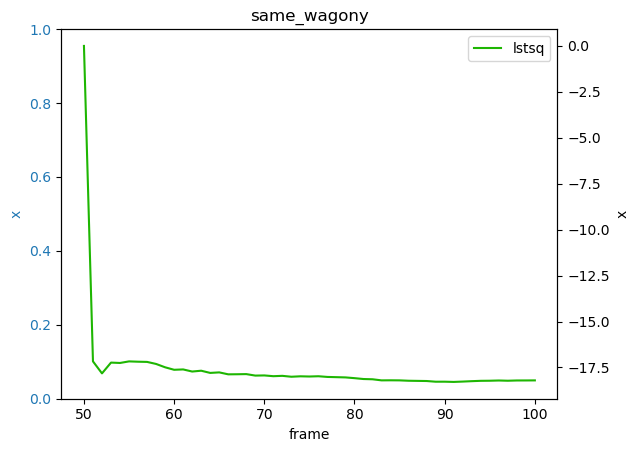

In [76]:
from speed_analyse_scripts.ComposedPlot import ComposedPlot
from matplotlib import pyplot as plt



def ax1_call(axe):
    color = "tab:blue"
    axe.set_xlabel("frame")
    axe.set_ylabel("x", color=color)
    axe.tick_params(axis='y', labelcolor=color)

def ax2_call(axe):
    axe.set_ylabel("x")

for dataset_name in files.keys():
    ax_callbacks = [ax1_call, ax2_call]
    Composed_x = ComposedPlot(dataset_name, *ax_callbacks)	

    colors = ["blue", "green", "orange", "purple"]

    # original = raw_velocities[dataset_name] 
    # x = original[:, 0]
    # y = original[:, 1]
    # Composed_x.add_plot(0, x, y, color="grey", label="original x")

    # _filtered = filtered[dataset_name] 
    # x = _filtered[:, 0]
    # y = _filtered[:, 1]
    # Composed_x.add_plot(1, x, y, color="grey", label="filtered x")
    
    selected_measurements = filter(lambda x: x.dataset_name == dataset_name, measurements)
    selected_measurements = list(selected_measurements)
    for measurement in selected_measurements:
        color = (np.random.random(), np.random.random(), np.random.random())
        
        array = np.array(measurement.results)
        x = array[:, 0]
        y = array[:, 1]
        Composed_x.add_plot(1, x, y, color=color, label=measurement.method_name)
    Composed_x.show_composed()

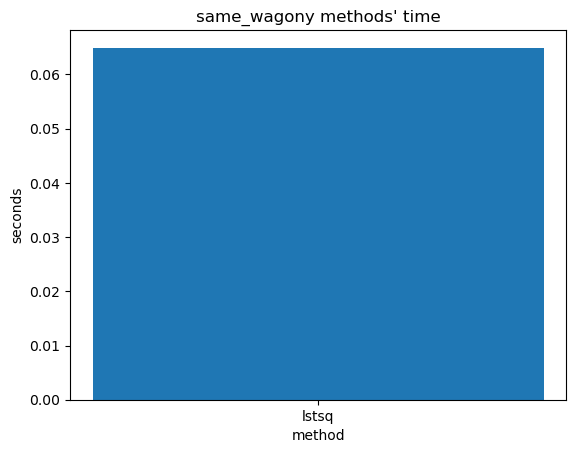

In [77]:
names = [i.method_name for i in measurements]
values = [i.timer.elapsed_time for i in measurements]
plt.bar(names, values)
plt.title(f"{dataset_name} methods' time")
plt.xlabel("method")
plt.ylabel("seconds")
plt.show()

In [78]:


dataset = 'same_wagony'
method = 'Filter'
def select_measurement(measurement):
    return measurement.dataset_name == dataset and measurement.method_name == method

selected_measurement = list(filter(select_measurement, measurements))[0]
results = np.array(selected_measurement.results)
x = results[:, 0]
y = results[:, 1]

plt.plot(x, y)
plt.title(f"{dataset} {method}")
plt.xlabel("frames")
plt.ylabel("x")
plt.show()


IndexError: list index out of range

In [ ]:
%run speed_analyse.py
print("end")

AttributeError: module '__main__' has no attribute '__spec__'

end


<Figure size 640x480 with 0 Axes>

In [ ]:
import time


t = Timer()
t.start()
time.sleep(3)
t.stop()

t.elapsed_time

3.014462471008301